In [24]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16*7*7, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        convHead = F.relu(self.conv1(x))
        convHead = self.pool(convHead)
        convHead = F.relu(self.conv2(convHead))
        convHead = self.pool(convHead)
        flatten = convHead.reshape(x.shape[0], -1)
        fcHead = self.fc1(flatten)
        fcHead = self.fc2(fcHead)
        return fcHead

In [6]:
#   Check output shape of model
model = CNN(1, 10)
x = torch.randn(32, 1, 28, 28)
model(x).shape

torch.Size([32, 10])

In [9]:
batch_size = 32
num_epochs = 5
input_size = 784
num_classes = 10
learning_rate = 1e-3
in_channels = 1

In [8]:
train_data = datasets.MNIST(root = 'Datasets\\', train = True, transform = transforms.ToTensor(), download = False)
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_data = datasets.MNIST(root = 'Datasets\\', train = False, transform = transforms.ToTensor(), download = False)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [19]:
model = CNN(in_channels, num_classes).to(device)

In [20]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = learning_rate)

In [21]:
loss_cummulative = []
for epoch in range(num_epochs):

    # if epoch != 0 and epoch % 2 == 0:
    #     checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    #     print(f'Epoch {epoch}:', loss_cummulative[-1])
    #     save_checkpoint(checkpoint)

    for (data, label) in train_loader:
        data = data.to(device)
        label = label.to(device)

        Y_pred = model(data)
        loss = loss_func(Y_pred, label)
        loss_cummulative.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

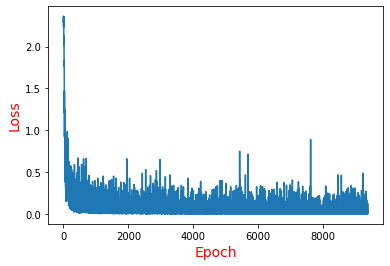

In [25]:
plt.plot(loss_cummulative)
plt.xlabel('Epoch', fontsize = 14, c = 'r')
plt.ylabel('Loss', fontsize = 14, c = 'r')
plt.show()

In [22]:
modelpath = 'modelpth'
torch.save(model.state_dict(), modelpath)

In [23]:
my_model = CNN(in_channels, num_classes).to(device)
my_model.load_state_dict(torch.load(modelpath))

<All keys matched successfully>

In [28]:
def check_acc(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)

            Y_pred = model(data)
            _, max_idx = Y_pred.max(dim = 1)

            num_correct += (max_idx == labels).sum()
            num_samples += Y_pred.shape[0]
        
        print(f"Got {num_correct}/{num_samples} with accuracy {num_correct/num_samples*100:.2f}")

In [29]:
check_acc(test_loader, my_model)

Got 9856/10000 with accuracy 98.56
